In [1]:
from qutip import *
from qutip.qip.operations import *
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random
from random import random 
from tqdm import tqdm
%matplotlib inline

In [12]:
def solve(s_init, t_list, t0, etaOmega, delta_z, w_z, phi_z, Nmax, waiton = False):
    tau_m = 5e-3
    H0 = -1j*etaOmega/2 * tensor(sigmap(), create(Nmax))    

    H1 = 1j*etaOmega/2 * tensor(sigmam(), destroy(Nmax))  
    
    Noise_Hz = delta_z * tensor(sigmaz(), qeye(Nmax)) 
    def Noise_Hz_coeff(t, args):
        return np.cos(w_z*t+phi_z)

    H = [H0, H1, [Noise_Hz, Noise_Hz_coeff]]

    c_ops = [tensor(qeye(2), np.sqrt(1/tau_m)*create(Nmax)*destroy(Nmax))]
    #c_ops = []
    if waiton:
        output = mesolve([[Noise_Hz, Noise_Hz_coeff]], s_init, t_list, c_ops, [])
    else:
        output = mesolve(H, s_init, t_list, c_ops, [])
    
    '''sz = []
    for i in range(len(output.states)):
        sz.append((output.states[i].ptrace(0)*sigmaz()).tr())
    plt.plot(t_list, sz)'''
    
    return output

In [7]:
import random as rd
def CPMG(tau, delta = 0, w = 0, loop = 4):  
    Nmax = 10
    nth = 0.0
    s0 = tensor(ket2dm(basis(2,1)),thermal_dm(Nmax, nth))
    #s0 = tensor(ket2dm(basis(2,1)),coherent_dm(Nmax, 2))
    
    t0 = 0.1e-3 # ms, pi time
    etaOmega = np.pi/t0/np.sqrt(1+nth)
    phi = rd.random()*2*np.pi
    
    # First step: pi/2 rotation
    t_start = 0
    t_stop = t0/2 #pi/2
    N_sample = 100

    s_init = s0
    t_list = np.linspace(t_start, t_stop, N_sample)
    output = solve(s_init, t_list, t0, etaOmega, delta, w, phi, Nmax, waiton = False)

    s_out = output.states[-1]

    for i in range(loop):
        # Wait
        if tau != 0:    
            t_start = t_stop
            if i == 0:
                t_stop = t_start + tau/2
            else:
                t_stop = t_start + tau
            N_sample = 100
            t_list = np.linspace(t_start, t_stop, N_sample)
            s_init = s_out

            output = solve(s_init, t_list, t0, etaOmega, delta, w, phi, Nmax, waiton = True)
            s_out = output.states[-1]

        # Pi rotation
        t_start = t_stop
        t_stop = t_start + t0
        N_sample = 100
        t_list = np.linspace(t_start, t_stop, N_sample)
        s_init = s_out

        output = solve(s_init, t_list, t0, etaOmega, delta, w, phi, Nmax, waiton = False)

        s_out = output.states[-1]
  
    # Wait
    if tau != 0:    
        t_start = t_stop
        t_stop = t_start + tau/2
        N_sample = 100
        t_list = np.linspace(t_start, t_stop, N_sample)
        s_init = s_out

        output = solve(s_init, t_list, t0, etaOmega, delta, w, phi, Nmax, waiton = True)
        s_out = output.states[-1]
        
    # Pi/2 rotation    
    t_start = t_stop
    t_stop = t_start + t0/2 #pi/2
    N_sample = 100

    s_init = s_out
    t_list = np.linspace(t_start, t_stop, N_sample)
    output = solve(s_init, t_list, t0, etaOmega, delta, w, phi, Nmax, waiton = False)

    s_final = output.states[-1].ptrace(0)
    return ((s_final*sigmaz()).tr()+1)/2
    #s5 = output.states[-1]
    #return [s0, s1, s2, s3, s4, s5]

def scan_wait_time(tau_list, delta, w, loop):
    probs = []
    for tau in tqdm(tau_list):
        exp = 50
        rs = 0
        for i in range(exp):
            rs += CPMG(tau, delta, w, loop)
        prob = rs/exp
        probs.append(prob)
         
    plt.figure()
    plt.plot(tau_list, probs, 'b-', label = 'exp', )
    plt.axhline(y = 0.5*(1+1/np.exp(1)), label = '1/e', color='r', linestyle='-')
    plt.axhline(y = 0.5, label = 'y = 0.5', color='g', linestyle='--')
    plt.ylim([-0.1,1.1])
    plt.legend()

100%|██████████| 11/11 [00:55<00:00,  5.01s/it]


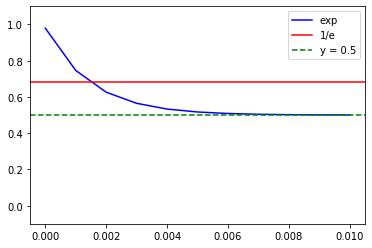

In [8]:
tau_list = np.linspace(0,10e-3,11)
scan_wait_time(tau_list, delta = 0, w = 0, loop = 4)

100%|██████████| 11/11 [00:57<00:00,  5.19s/it]


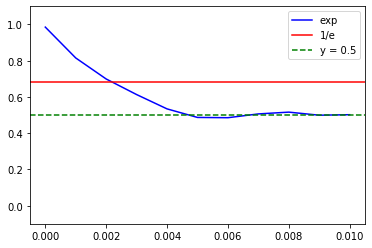

In [13]:
tau_list = np.linspace(0,10e-3,11)
scan_wait_time(tau_list, delta = 1e3, w = 200, loop = 4)

100%|██████████| 51/51 [05:27<00:00,  6.43s/it]


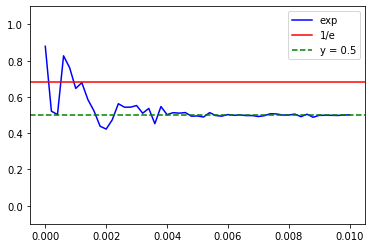

In [14]:
tau_list = np.linspace(0,10e-3,51)
scan_wait_time(tau_list, delta = 5e3, w = 400, loop = 4)

100%|██████████| 51/51 [16:13<00:00, 19.08s/it]


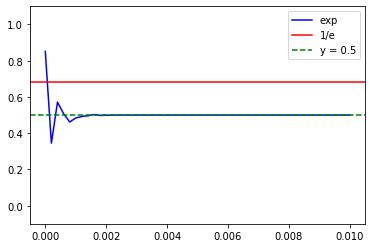

In [54]:
tau_list = np.linspace(0,10e-3,51)
scan_wait_time(tau_list, delta = 5e3, w = 200, loop = 20)